# Introduction to Data Science
## Homework 4 

Student Name: Xinmeng Li

Student Netid: xl1575
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [91]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
def cleanBosonData(infile_name):
    df = pd.read_csv(infile_name)
    df = df.set_index('EventId')
    mino = df.groupby('Label').size().index[0]
    if df.groupby('Label').size()[0]>df.groupby('Label').size()[1]:
        mino = df.groupby('Label').size().index[1]
    df['Y'] = [1 if i==mino else 0 for i in df['Label']]
    df = df.drop('Label',axis=1)
    binary = ['Y']
    for col in df:
        if (df[col] == -999).sum()>0:
            df[col + '_mv'] =  [1 if i==-999 else 0 for i in df[col]]
            avr = np.mean([i for i in df[col] if i!=-999])
            df[col] = df[col].replace(-999,avr)
            binary.append(col+ '_mv')
    data_clean = preprocessing.scale(df.drop(binary,axis=1))
    c = list(df.columns)[:len(list(df.columns))-len(binary)]
    data_clean = pd.DataFrame(data=data_clean,columns = c,index = df.index.values)
    for b in binary:
        data_clean[b] = df[b]
    return data_clean

### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [92]:
#Student put code here
data_train = cleanBosonData('boson_training_cut_2000.csv')
data_test = cleanBosonData('boson_testing_cut.csv')
data_train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193e+00,0.888048,1.120050,1,0,0,0,0
100001,8.633960e-01,0.608117,0.639363,-0.120744,-4.978417e-16,2.786711e-16,6.148512e-17,1.421917,-0.806390,0,0,1,1,1
100002,-5.882872e-16,3.421843,1.261884,-0.321306,-4.978417e-16,2.786711e-16,6.148512e-17,0.997693,-0.455521,0,1,1,1,1
100003,5.108589e-01,0.989159,0.028516,-0.885926,-4.978417e-16,2.786711e-16,6.148512e-17,1.209152,-0.886831,0,0,1,1,1
100004,1.172363e+00,-0.953916,1.504447,-0.629578,-4.978417e-16,2.786711e-16,6.148512e-17,1.967534,-0.113790,0,0,1,1,1


2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
X_train = data_train.drop('Y',axis=1)
Y_train = data_train['Y']
X_test = data_test.drop('Y',axis=1)
Y_test = data_test['Y']
clf = LogisticRegression(C=1e30)
clf.fit(X_train, Y_train)
print('Logistic regression train accuracy: ',clf.score(X_train,Y_train),' test accuracy: ', clf.score(X_test,Y_test))
clf2 = SVC(kernel='linear',probability=True)
clf2.fit(X_train, Y_train)
print('Linear SVM train accuracy: ',clf2.score(X_train,Y_train),' test accuracy: ', clf2.score(X_test,Y_test))

Logistic regression train accuracy:  0.702851425713  test accuracy:  0.71992
Linear SVM train accuracy:  0.695847923962  test accuracy:  0.69674


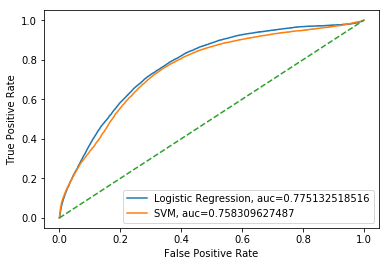

In [94]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
%matplotlib inline
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)

y_pred_proba2 = clf2.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = roc_curve(Y_test,  y_pred_proba2)
auc2 = roc_auc_score(Y_test, y_pred_proba2)

fpr3, tpr3, _ = roc_curve(Y_test, [0 for _ in range(len(Y_test))])
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.plot(fpr2,tpr2,label="SVM, auc="+str(auc2))
plt.plot(fpr3,tpr3,linestyle='--',)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show() 

In [159]:
import bisect
def gettpr(x):
    nearest_fpr = bisect.bisect_left(fpr, x) 
    print("Logistic Regression: fpr = ",fpr[nearest_fpr],',tpr = ', tpr[list(fpr).index(fpr[nearest_fpr])])
    nearest_fpr2 = bisect.bisect_left(fpr2, x) 
    print("SVM: fpr = ",fpr2[nearest_fpr2], ',tpr = ', tpr2[list(fpr2).index(fpr2[nearest_fpr])])

In [177]:
gettpr(0)
gettpr(0.01)
gettpr(0.078)
gettpr(0.079)
gettpr(0.3)
gettpr(0.6)
gettpr(0.9)
gettpr(1)

Logistic Regression: fpr =  0.0 ,tpr =  5.82648721086e-05
SVM: fpr =  0.0 ,tpr =  5.82648721086e-05
Logistic Regression: fpr =  0.0100496391266 ,tpr =  0.0781914583697
SVM: fpr =  0.0100496391266 ,tpr =  0.0900774922799
Logistic Regression: fpr =  0.0780217437647 ,tpr =  0.309561265513
SVM: fpr =  0.0782349179279 ,tpr =  0.309969119618
Logistic Regression: fpr =  0.0790571611292 ,tpr =  0.313698071433
SVM: fpr =  0.0790267076773 ,tpr =  0.312998892967
Logistic Regression: fpr =  0.300392849529 ,tpr =  0.72533939288
SVM: fpr =  0.300027408107 ,tpr =  0.716191807959
Logistic Regression: fpr =  0.600359350732 ,tpr =  0.926702790887
SVM: fpr =  0.600511617992 ,tpr =  0.916215113908
Logistic Regression: fpr =  0.900356305387 ,tpr =  0.975528753714
SVM: fpr =  0.900508572647 ,tpr =  0.965390665967
Logistic Regression: fpr =  1.0 ,tpr =  1.0
SVM: fpr =  1.0 ,tpr =  0.989745382509


3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Since the ROC curves of these two models almost overlap with each other, observing by naked eyes cannot guarantee the accuracy of our statement. As a result, I write a function gettpr(x) to find the tpr value corresponding to a given fpr on the graph. Combining above figure and print out statements, we observe that the curve of logistic regression is slightly higher than SVM at the most time. Therefore, logistic regression is generally better. <br>After plugging various values of fpr, I found out that when fpr <= 0.78, SVM has a better performance than Logistic Regression. The above print out statements shows the threshold clearly.

### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Use sklearn.model_selection.KFold to map each instance to a fold
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to previously defined fold mappings
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

Note: Use Sklearn's KFold method, but do not use any other cross-validation convenience function. The goal is to learn how to implement the algorithm yourself!

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [95]:
#Don't forget to import any relevant libraries (i.e., sklearn.cross_validation)
from sklearn.model_selection import KFold
def xValSVM(dataset, label_name, k, cs):
    kfold = KFold(n_splits=k)
    aucs = {k:[] for k in cs}
    for cv_train, cv_validate in kfold.split(dataset):
        aa = []
        for c in cs:
            clf = SVC(kernel='linear',C=c,probability=True)
            clf.fit(dataset.iloc[cv_train].drop(label_name,axis=1), dataset.iloc[cv_train][label_name])
            y_pred_proba = clf.predict_proba(dataset.iloc[cv_validate].drop(label_name,axis=1))[::,1]
            AUC_c_k = roc_auc_score(dataset.iloc[cv_validate][label_name], y_pred_proba)
            aucs[c].append(AUC_c_k)
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [96]:
cs = [10**i for i in range(-8,2)]
print(cs)
aucs = xValSVM(data_train, 'Y', 10, cs)

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]


when c =  1 , we get max_1std =  0.739600208319


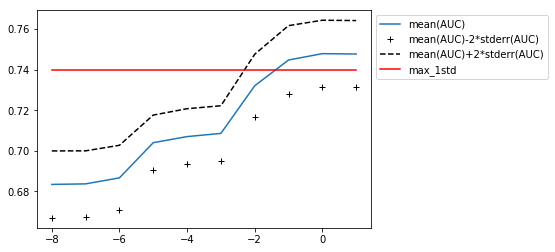

In [98]:
meanauc = []
stdeauc = []
for c in cs:
    meanauc.append(np.mean(aucs[c]))
    stdeauc.append(np.sqrt(np.var(aucs[c])/len(aucs[c])))
max_ci = meanauc.index(max(meanauc))
max_1std = meanauc[max_ci]-stdeauc[max_ci]
print('when c = ',cs[max_ci],', we get max_1std = ',max_1std)
meanauc = np.array(meanauc)
stdeauc = np.array(stdeauc)
xaxis = [np.log10(c) for c in cs]
plt.subplot()
plt.plot(xaxis, meanauc,label = 'mean(AUC)')
plt.plot(xaxis, meanauc-2*stdeauc,'k+',label = 'mean(AUC)-2*stderr(AUC)')
plt.plot(xaxis, meanauc+2*stdeauc,'k--',label = 'mean(AUC)+2*stderr(AUC)')
plt.plot(xaxis, [max_1std]*len(cs),'r',label = 'max_1std')
plt.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [102]:
clf2 = SVC(kernel='linear',probability=True,C=1)
clf2.fit(X_train, Y_train)
print('train accuracy when C=1: ',clf2.score(X_train,Y_train),' test accuracy: ', clf2.score(X_test,Y_test))
clf2 = SVC(kernel='linear',probability=True,C=0.1)
clf2.fit(X_train, Y_train)
print('train accuracy when C=0.1: ',clf2.score(X_train,Y_train),' test accuracy: ', clf2.score(X_test,Y_test))

train accuracy when C=1:  0.695847923962  test accuracy:  0.69674
train accuracy when C=0.1:  0.695847923962  test accuracy:  0.69552


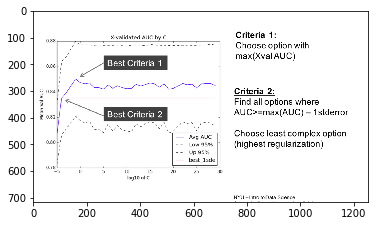

In [137]:
import matplotlib.image as mpimg
img = mpimg.imread('criterion.png') 
plt.imshow(img)

No. The default value of C in the out-of-the-box model is 1. During the process of calculating max_1std, I observed that the C value having the maximum mean(AUC) is also 1. According the above screenshots from the lecture note, there are two criterias to select optimal C. By the first criteria, we choose C = 1; by the second criteria, we choose C = 0.1. According to the accuracy and AUC, both of the two models with these two possible valus of optimal C have almost same performance as the out-of-the-box model.

### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the linear kernel and value of C identified using the 1 standard error method from part 3. For LR, use the default C.  
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list
    
-	Returns the mean(AUC) and Standard Deviation(AUC) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so just use np.sqrt(np.var(...))


In [88]:
# Code here
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    df_train = cleanBosonData(train)
    df_test = cleanBosonData(test)
    auclist = []
    for i in range(0,nruns):
        #rani = np.random.choice(len(df_train), sampsize, replace=True)
        sample = df_train.sample(n=sampsize, replace=True)
        #sample = df_train.iloc[rani]
        if lr ==1:
            clf = LogisticRegression()
        else:
            clf = SVC(kernel='linear',C=c,probability=True)
        clf.fit(sample.drop('Y',axis=1), sample['Y'])
        y_pred_proba = clf.predict_proba(df_test.drop('Y',axis=1))[::,1]
        auc = roc_auc_score(df_test['Y'], y_pred_proba)
        auclist.append(auc)
    aucs = [np.mean(auclist),np.std(auclist)]
    return aucs

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs). For SVM, use the value of C identified using the 1 standard error method from part 3. For LR, use the default C.

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-2*stddev(AUC) (note: standard deviation, not standard error) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+2*stddev(AUC) (note: standard deviation, not standard error) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [89]:
#Code here
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
lr = []
SVM = []
train_file = 'boson_training_cut_2000.csv'
test_file = 'boson_testing_cut.csv'
for s in samplesizes:
    lr.append(modBootstrapper(train_file, test_file, 20, s, 1,0))
    # Here I use optimal C = 0.1 based on the second criteria. Please refer to  
    # Part 3 for the process of optimal C selection.
    SVM.append(modBootstrapper(train_file, test_file, 20, s, 0, 0.1))

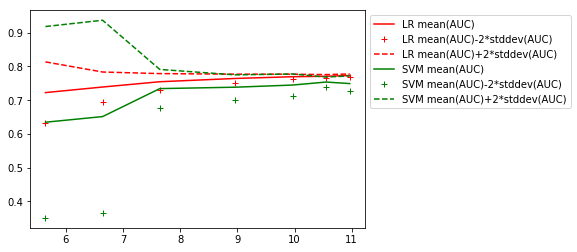

In [109]:
plt.subplot()
mean_lr = np.array([t[0] for t in lr])
std_lr = np.array([t[1] for t in lr])
mean_svm = np.array([t[0] for t in SVM])
std_svm = np.array([t[1] for t in SVM])
slist = [np.log2(s) for s in samplesizes]
plt.plot(slist, mean_lr,'r',label = 'LR mean(AUC)')
plt.plot(slist, mean_lr-2*std_lr,'r+',label = 'LR mean(AUC)-2*stddev(AUC)')
plt.plot(slist, mean_lr+2*std_lr,'r--',label = 'LR mean(AUC)+2*stddev(AUC)')
plt.plot(slist, mean_svm,'g',label = 'SVM mean(AUC)')
plt.plot(slist, mean_svm-2*std_svm,'g+',label = 'SVM mean(AUC)-2*stddev(AUC)')
plt.plot(slist, mean_svm+2*std_svm,'g--',label = 'SVM mean(AUC)+2*stddev(AUC)')
plt.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


Logistic regression is more suitable, because it generally has a larger mean(AUC) and smaller standard deviation. With the larger AUC, logistic regression can distinguish the binary classes better. With the smaller standard error, the logistic regression has a smaller confidence interval, thus makes more precise estimate. <br>
No. Clearly, there is almost no need for doubling the data when the sample size>=2^7.8. We observe that the mean AUC increases very slowly when it is greater than the point at around log2(samplesize) = 7.8. Moreover, although the standard error at the beginning is relatively large, it is not worthy to pay for twice of the investment to improve it. If we want to use the model to make a decision, we can run the model more times to make sure our prediction is not an outlier (i.e. closer to the mean(AUC) curve).

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?

According to the ESL figure 7.8 of 1 − Err versus the size of the training set N, when the training set is small (i.e. when N<=around 70), the training set that the k-fold will use will have a different performance. Therefore, according to The Chapter 7 of Elements of $Statistical Learning Data Mining, Inference, and Prediction$, "That would be an underestimate of 1 − Err. Hence as an estimate of Err, cross-validation would be biased upward."(Trevor Hastie, Robert Tibshirani, Jerome Friedman)